In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import random, math, os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [21]:
import pickle
BASE_PATH = "/kaggle/input/cifar-10-and-cifar-10-c/cifar-10-python/cifar-10-batches-py"

def unpickle(file):
    with open(file ,'rb') as f:
        data_dict = pickle.load(f , encoding = 'bytes')
    return data_dict

In [22]:
test_data = []
test_label = []

test_path = os.path.join(BASE_PATH , 'test_batch')
test_batch = unpickle(test_path)
test_data.append(test_batch[b'data'])
test_label.extend(test_batch[b'labels'])

y_test = np.array(test_label)    

In [23]:
def cifar_flat_to_pil(img_flat):
    r = img_flat[0:1024].reshape(32,32)
    g = img_flat[1024:2048].reshape(32,32)
    b = img_flat[2048:3072].reshape(32,32)
    img = np.stack([r,g,b], axis=2).astype('uint8')
    pil_img = Image.fromarray(img).convert("RGB")
    return pil_img

# Converting a Fla

In [24]:
from PIL import Image
def cifar_dataset_to_pil(flat_images):
    pil_images = []
    for img_flat in flat_images:
        pil_img = cifar_flat_to_pil(img_flat)  # pass the array directly
        pil_images.append(pil_img)
    return pil_images

test_data_flat = np.vstack(test_data)   
test_images = cifar_dataset_to_pil(test_data_flat)

In [25]:
import torch

model_path = "/kaggle/input/wec-task-3/pytorch/default/1/best_model.pth"
state_dict = torch.load(model_path, map_location='cpu')

for k, v in state_dict.items():
    print(k, v.shape)


conv1.weight torch.Size([64, 3, 3, 3])
conv1.bias torch.Size([64])
conv2.weight torch.Size([128, 64, 3, 3])
conv2.bias torch.Size([128])
conv3.weight torch.Size([128, 128, 3, 3])
conv3.bias torch.Size([128])
conv4.weight torch.Size([256, 128, 3, 3])
conv4.bias torch.Size([256])
conv5.weight torch.Size([256, 256, 3, 3])
conv5.bias torch.Size([256])
conv6.weight torch.Size([256, 256, 3, 3])
conv6.bias torch.Size([256])
conv7.weight torch.Size([512, 256, 3, 3])
conv7.bias torch.Size([512])
conv8.weight torch.Size([512, 512, 3, 3])
conv8.bias torch.Size([512])
conv9.weight torch.Size([512, 512, 3, 3])
conv9.bias torch.Size([512])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
bn1.running_mean torch.Size([64])
bn1.running_var torch.Size([64])
bn1.num_batches_tracked torch.Size([])
bn2.weight torch.Size([256])
bn2.bias torch.Size([256])
bn2.running_mean torch.Size([256])
bn2.running_var torch.Size([256])
bn2.num_batches_tracked torch.Size([])
bn3.weight torch.Size([512])
bn3.bias torc

In [26]:
class AdvancedCNNCheckpoint(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv7 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, 3, padding=1)

        # BatchNorm layers
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(512)

        # Pooling + dropout
        self.maxpool = nn.MaxPool2d(2,2)
        self.dropout = nn.Dropout2d(0.2)

        # Fully connected layers (matches checkpoint exactly)
        self.fc1 = nn.Linear(512*4*4, 8192)
        self.fc2 = nn.Linear(8192, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.maxpool(x)

        x = self.relu(self.bn2(self.conv4(x)))
        x = self.relu(self.conv5(x))
        x = self.relu(self.conv6(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.relu(self.bn3(self.conv7(x)))
        x = self.relu(self.conv8(x))
        x = self.relu(self.conv9(x))
        x = self.maxpool(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = AdvancedCNNCheckpoint(num_classes=10)

state_dict = torch.load(model_path, map_location=device)
net.load_state_dict(state_dict)
net.to(device)
net.eval()

AdvancedCNNCheckpoint(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [28]:
all_predictions = []
all_true_labels = []
all_correct_flags = []

net.eval()
with torch.no_grad():
    for img, label in zip(test_images, test_label):
        img_tensor = preprocess_image(
            np.float32(img)/255.0,
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ).to(device)

        outputs = net(img_tensor)
        pred = outputs.argmax(dim=1).item()

        all_predictions.append(pred)
        all_true_labels.append(label)
        all_correct_flags.append(pred == label)

In [29]:
correct_indices = [i for i, correct in enumerate(all_correct_flags) if correct]
misclassified_indices = [i for i, correct in enumerate(all_correct_flags) if not correct]

print(len(correct_indices))
print(len(misclassified_indices))

9095
905


In [30]:
import random

num_samples = 10

random_correct_indices = random.sample(correct_indices, min(num_samples, len(correct_indices)))
random_wrong_indices = random.sample(misclassified_indices, min(num_samples, len(misclassified_indices)))

print("Random Correctly Classified Indices:", random_correct_indices)
print("Random Misclassified Indices:", random_wrong_indices)


Random Correctly Classified Indices: [7186, 4647, 2324, 658, 3970, 5536, 8587, 9897, 4745, 7438]
Random Misclassified Indices: [7183, 4139, 3192, 4121, 4931, 8066, 8364, 7792, 2141, 7906]


#We are now using this for EIGEN CAM

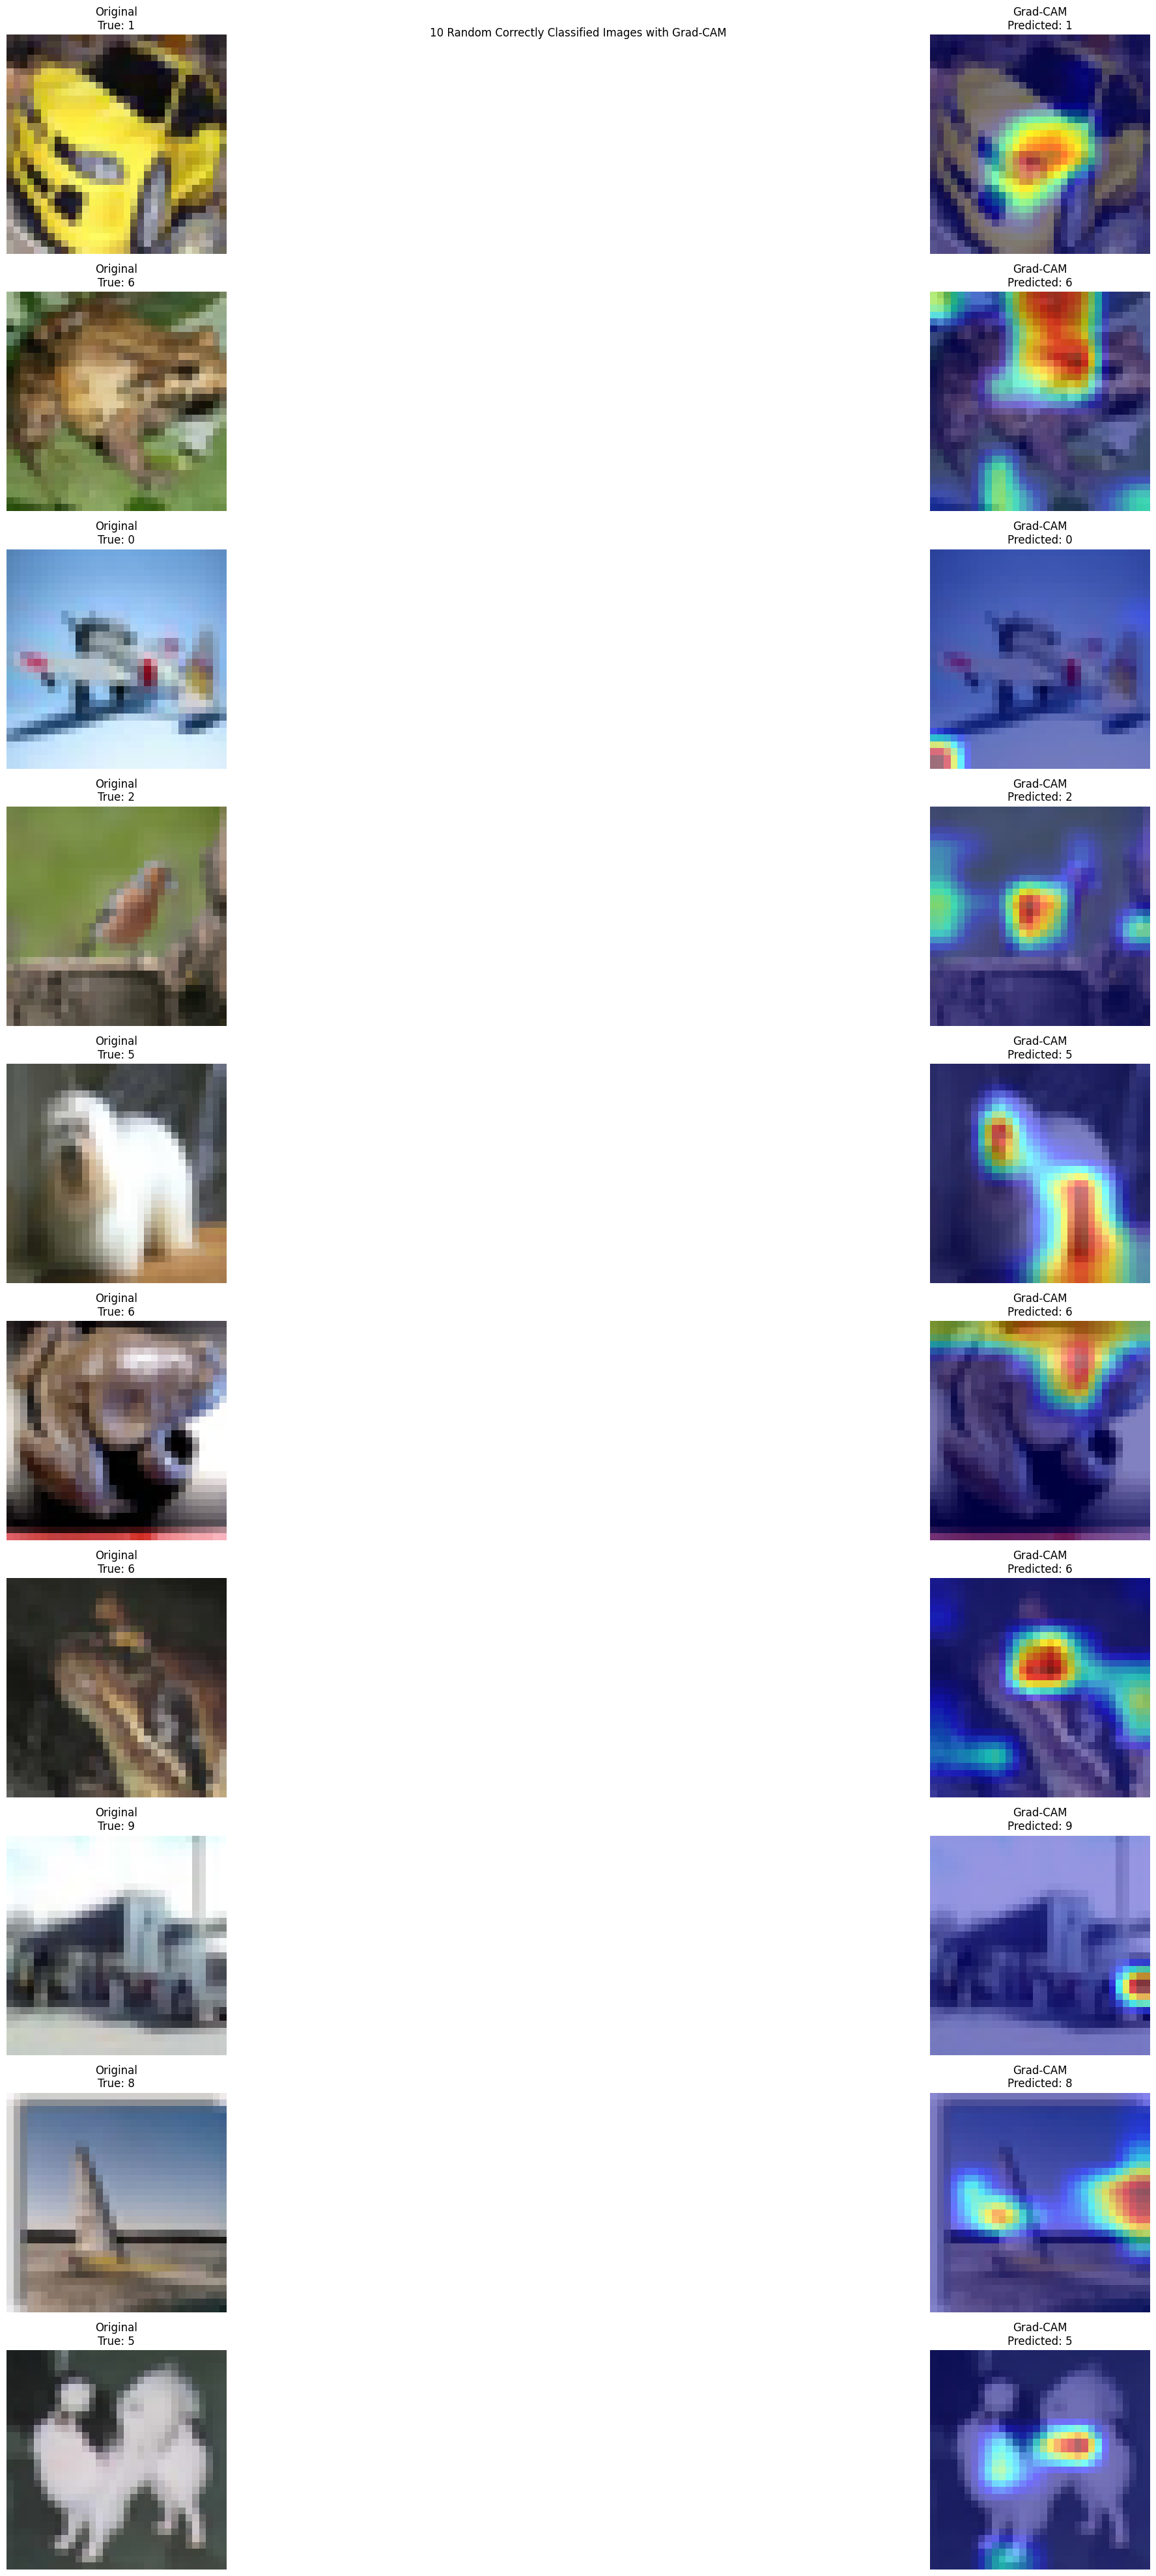

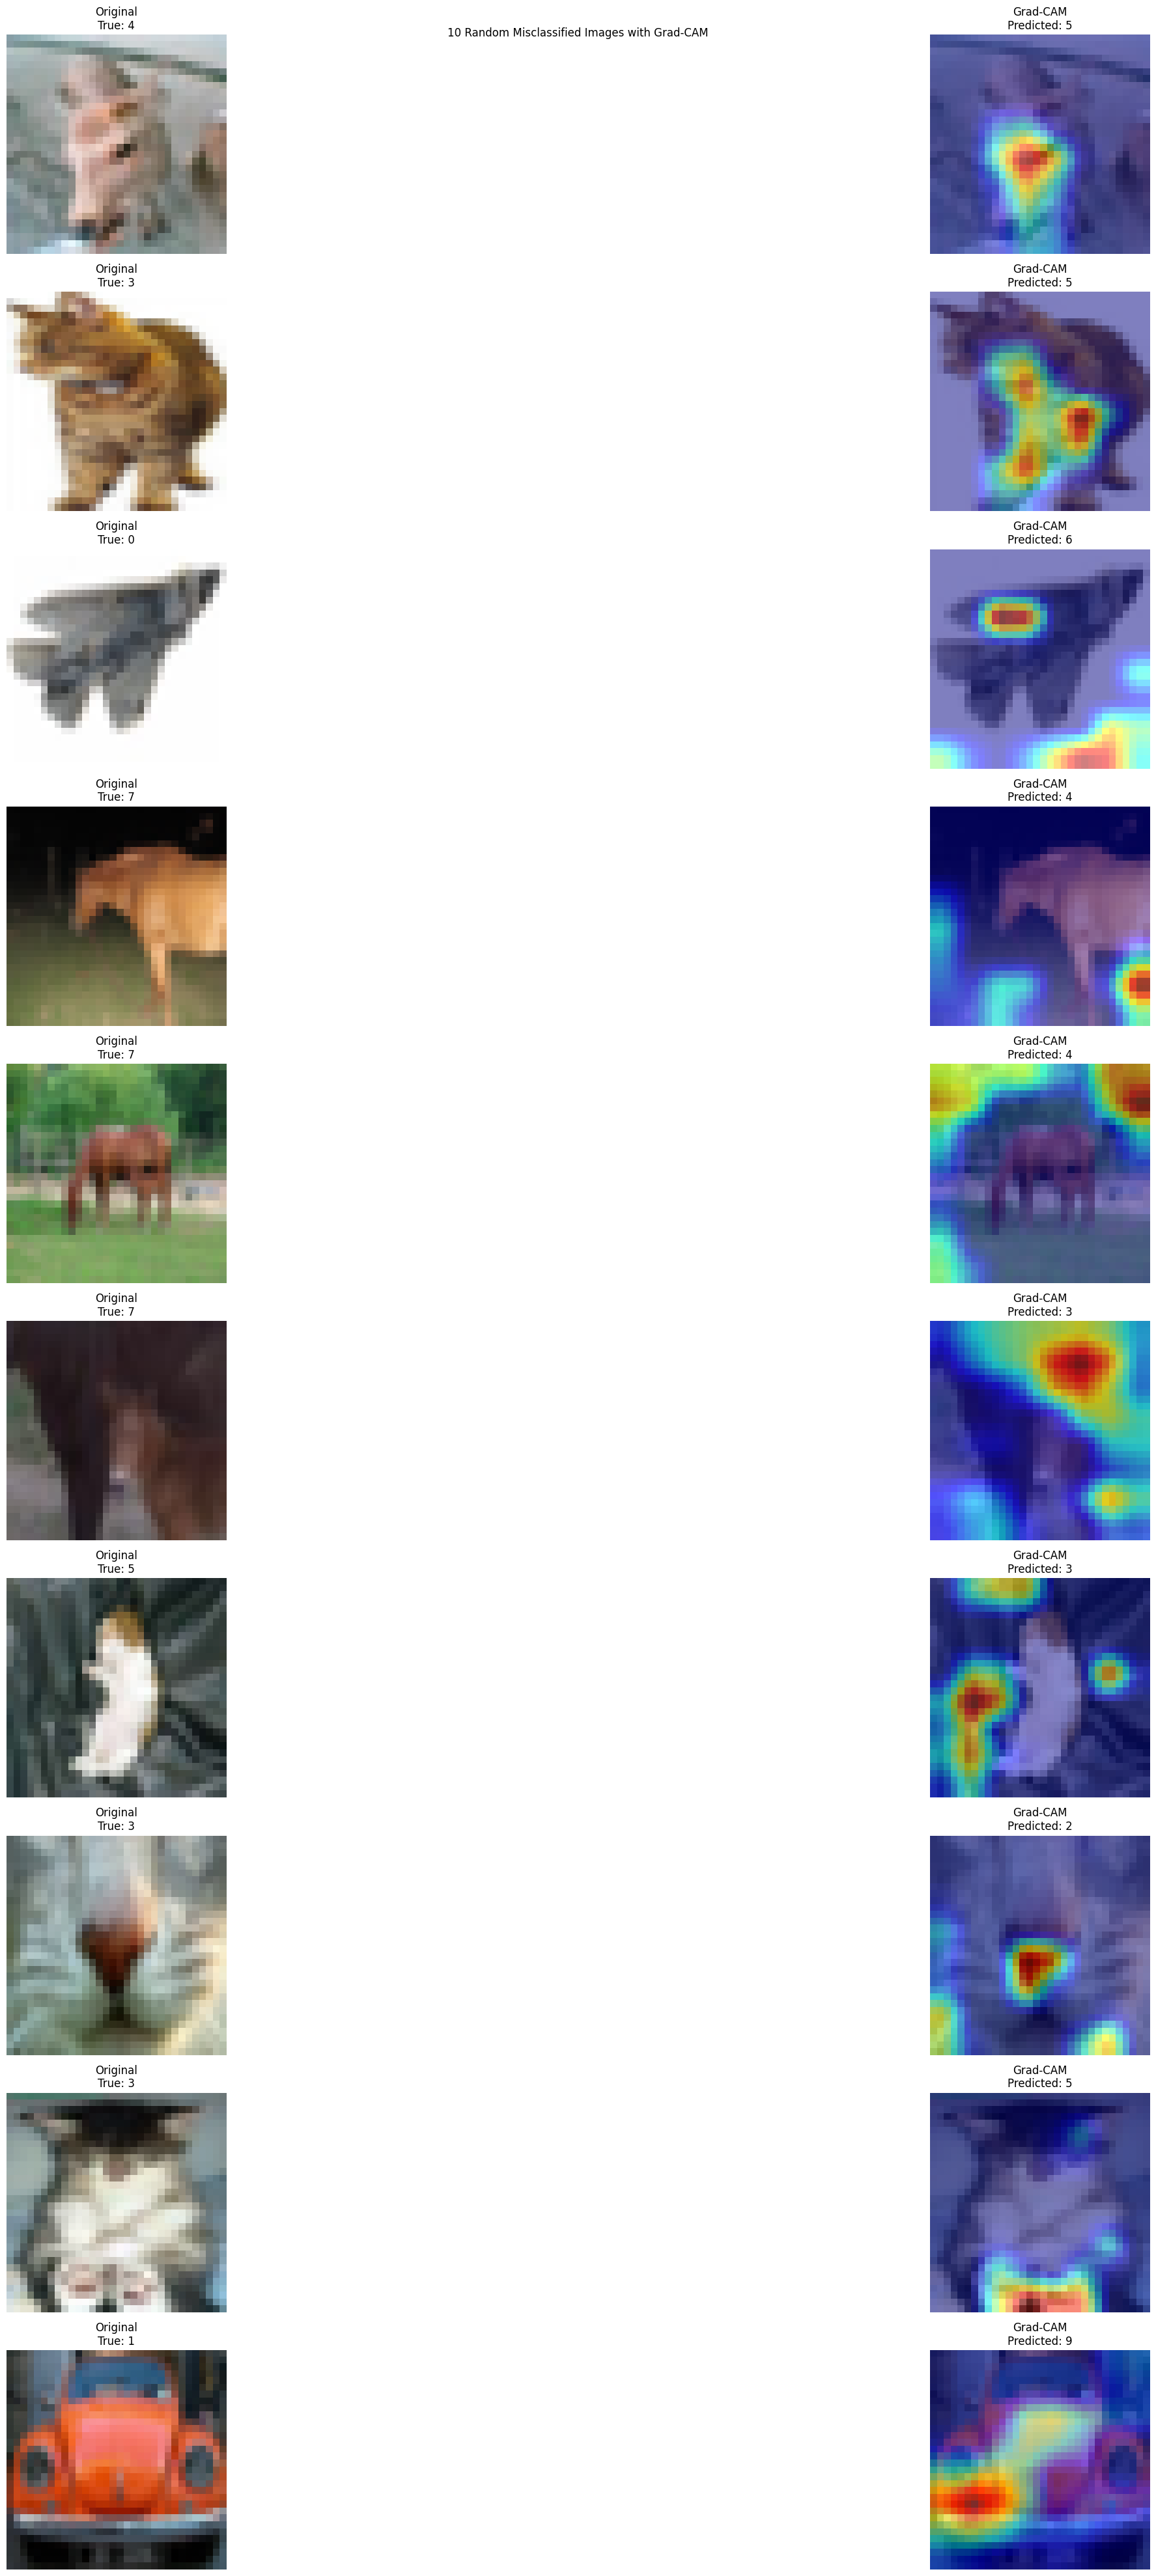

In [31]:
# Number of images to visualize
num_samples = 10

# Randomly sample indices
random_correct_indices = random.sample(correct_indices, min(num_samples, len(correct_indices)))
random_wrong_indices = random.sample(misclassified_indices, min(num_samples, len(misclassified_indices)))

# Set target layers and Grad-CAM
target_layers = [net.conv8]
cam = GradCAM(model=net, target_layers=target_layers)

# Function to get Grad-CAM overlay
def get_gradcam_image(index):
    test_image = test_images[index]
    image_np = np.float32(test_image) / 255.0

    input_tensor = preprocess_image(
        image_np,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ).to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(input_tensor)
        predicted_class = outputs.argmax(dim=1).item()

    grayscale_cam = cam(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(predicted_class)]
    )[0, :]

    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    return image_np, cam_image, predicted_class

# Plot all 10 correct images
plt.figure(figsize=(40, 40))
for i, idx in enumerate(random_correct_indices):
    orig, cam_img, pred = get_gradcam_image(idx)
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original\nTrue: {all_true_labels[idx]}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM\nPredicted: {pred}")
    plt.axis("off")

plt.suptitle("10 Random Correctly Classified Images with Grad-CAM")
plt.tight_layout()
plt.show()

# Plot all 10 misclassified images
plt.figure(figsize=(40, 40))
for i, idx in enumerate(random_wrong_indices):
    orig, cam_img, pred = get_gradcam_image(idx)
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original\nTrue: {all_true_labels[idx]}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(cam_img)
    plt.title(f"Grad-CAM\nPredicted: {pred}")
    plt.axis("off")

plt.suptitle("10 Random Misclassified Images with Grad-CAM")
plt.tight_layout()
plt.show()


Grad-CAM highlights regions that most influence the model’s prediction by weighting the last convolutional layer’s feature maps using class-specific gradients. For misclassified images, it often focuses on the main object but sometimes attends to sub-regions or background, showing that the model generally looks at meaningful areas, yet subtle or misleading features can cause errors.

If we go by particular cases :

1) The main observation i made was when the model is very conifdent about its predictions it gives a probability nearly 1 so there is no observations on the heatmap.
2) The model learnt that if there is a clear or similar kind of pixels nearby for a small considerable distance it classsified it is an airplane
3) If there was a sky shot picutre then it went wrong as landscape is different in different regions so it got confused here
4) In most of the misclassifcations it has been due to background showing the importance of background rather than the object class
   
6) In case of Airplane and Bird it again got confused in case of ground shot picutre if the sky
7) So this tells us the importance of the detailing we need to give to the model or how in depth it analyses the information which is truly mindblowing

But now speaking of the disadvantages of this Grad_CAM 

1) We can't just rely on the GRAD-CAM for understanding the importance given to each feature as GRADIENTS is just measure of sensitivity i mean it just measures how the model output changes if we change certain weights and bias. It captures only the local feautres and leaves out the global level analysis

2) Sometimes, even in classification models, the gradient signal is a mess ,this happens when the model is overconfident (output logits are huge — softmax saturates, gradients vanish),even the case of Dead ReLU's in these cases we get out a falt ouput in the heatmap directly indicating inefficiency in the model

3) It fails very badly on multi-class images if present during classification which means that suppose we have a Airplane flying in the air as we saw in our case the Heatmap was more concerned about the Sky rather than the object which means that model is not able to get the context in multi label images

So these are the major disadvantages i observed

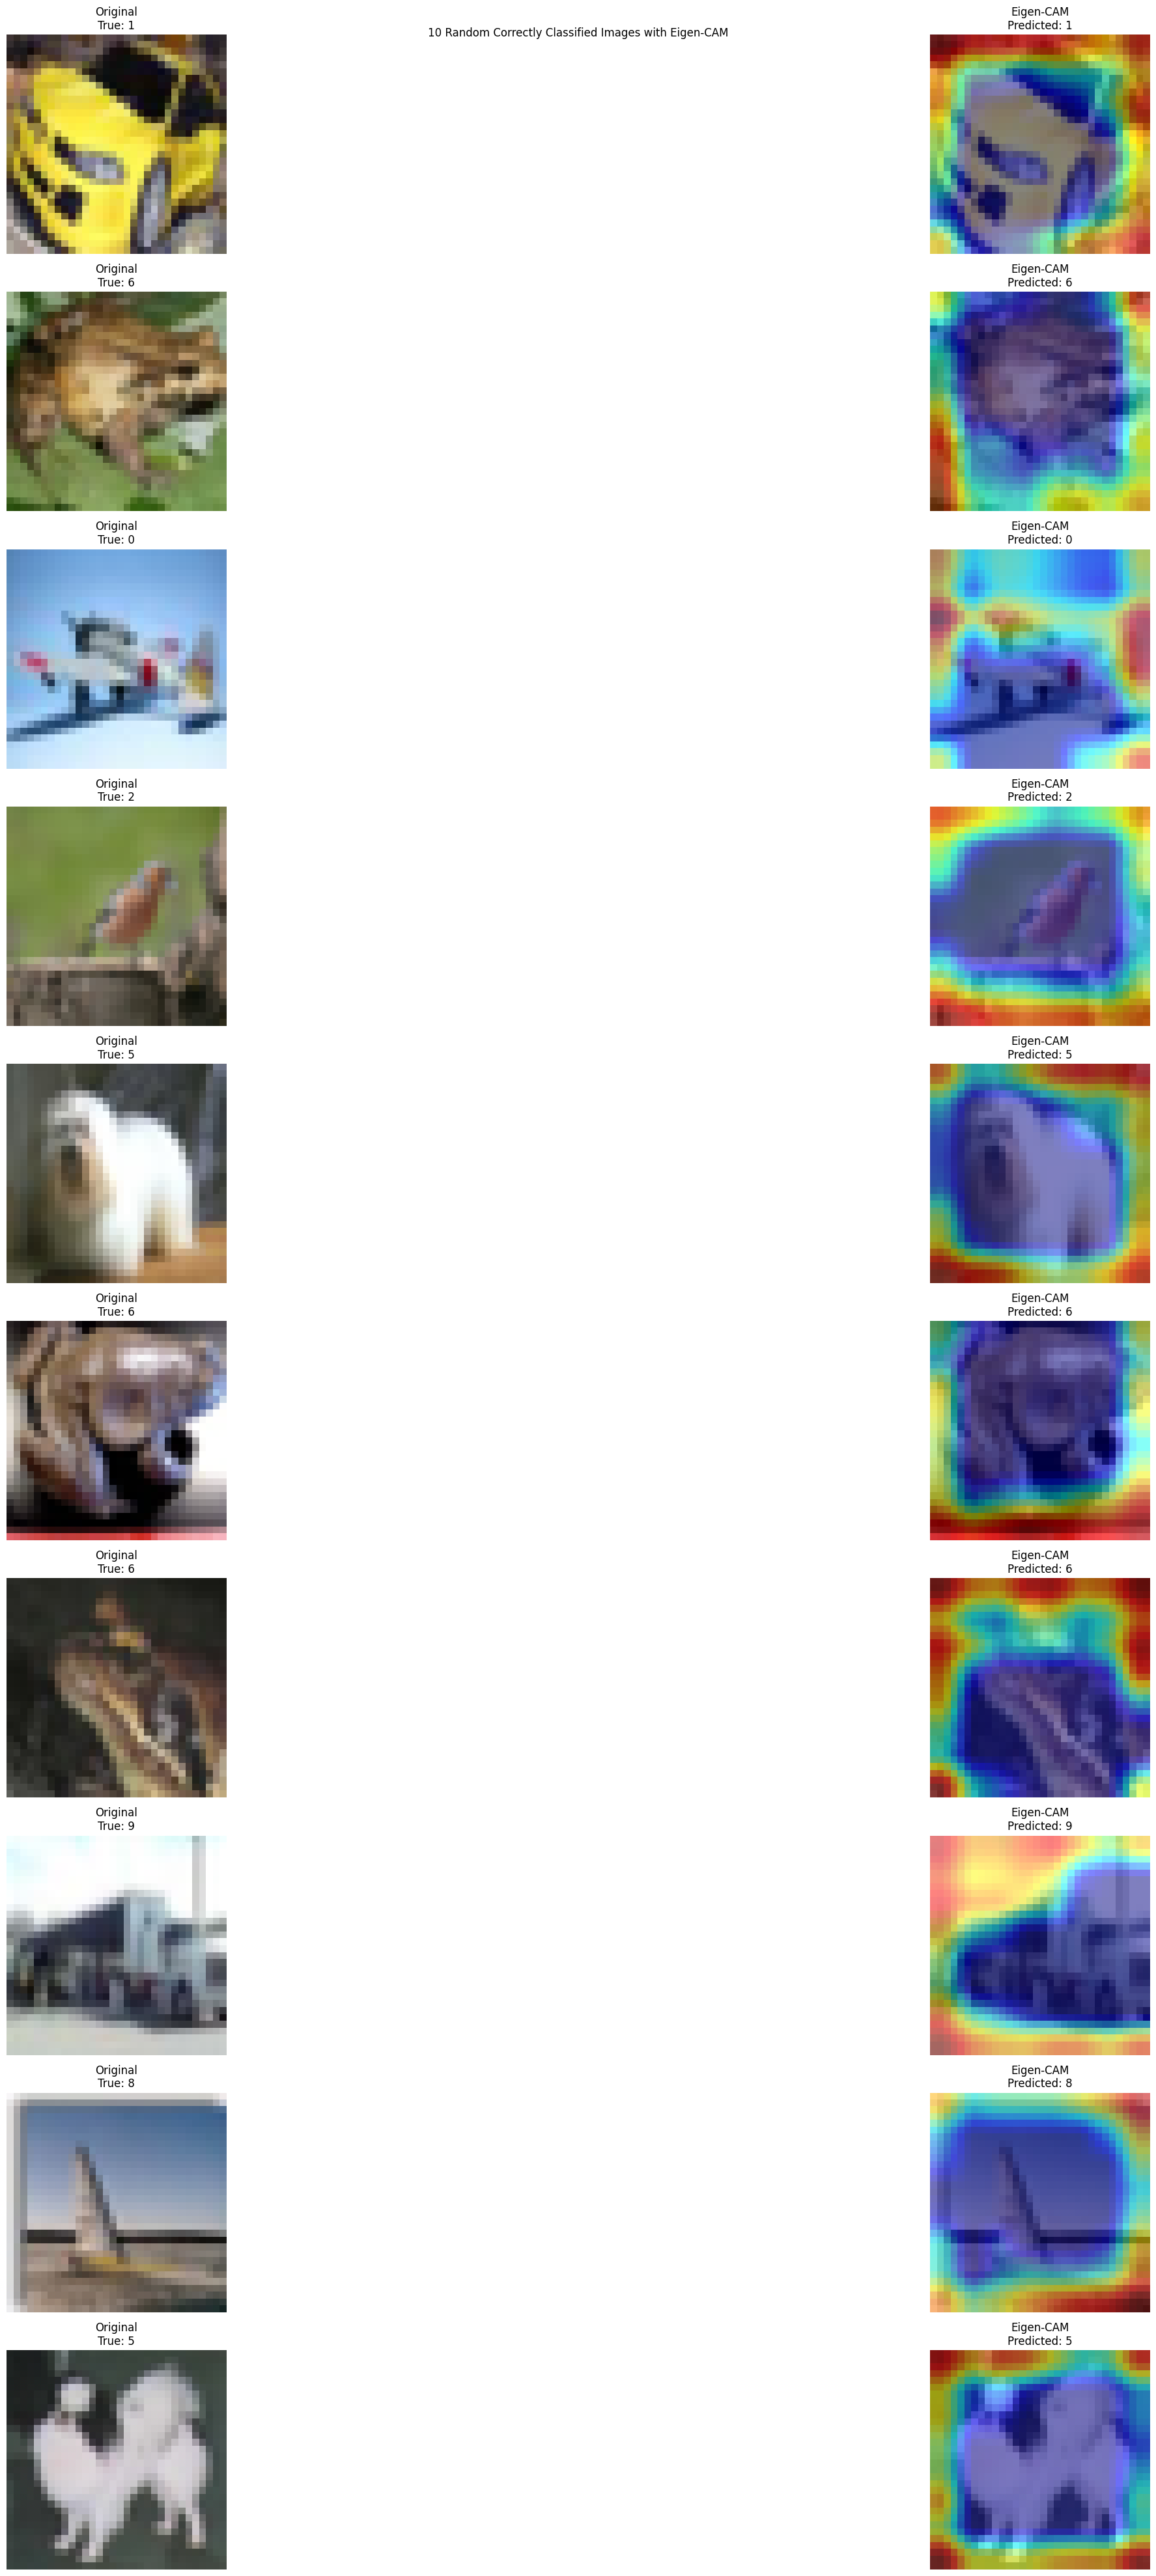

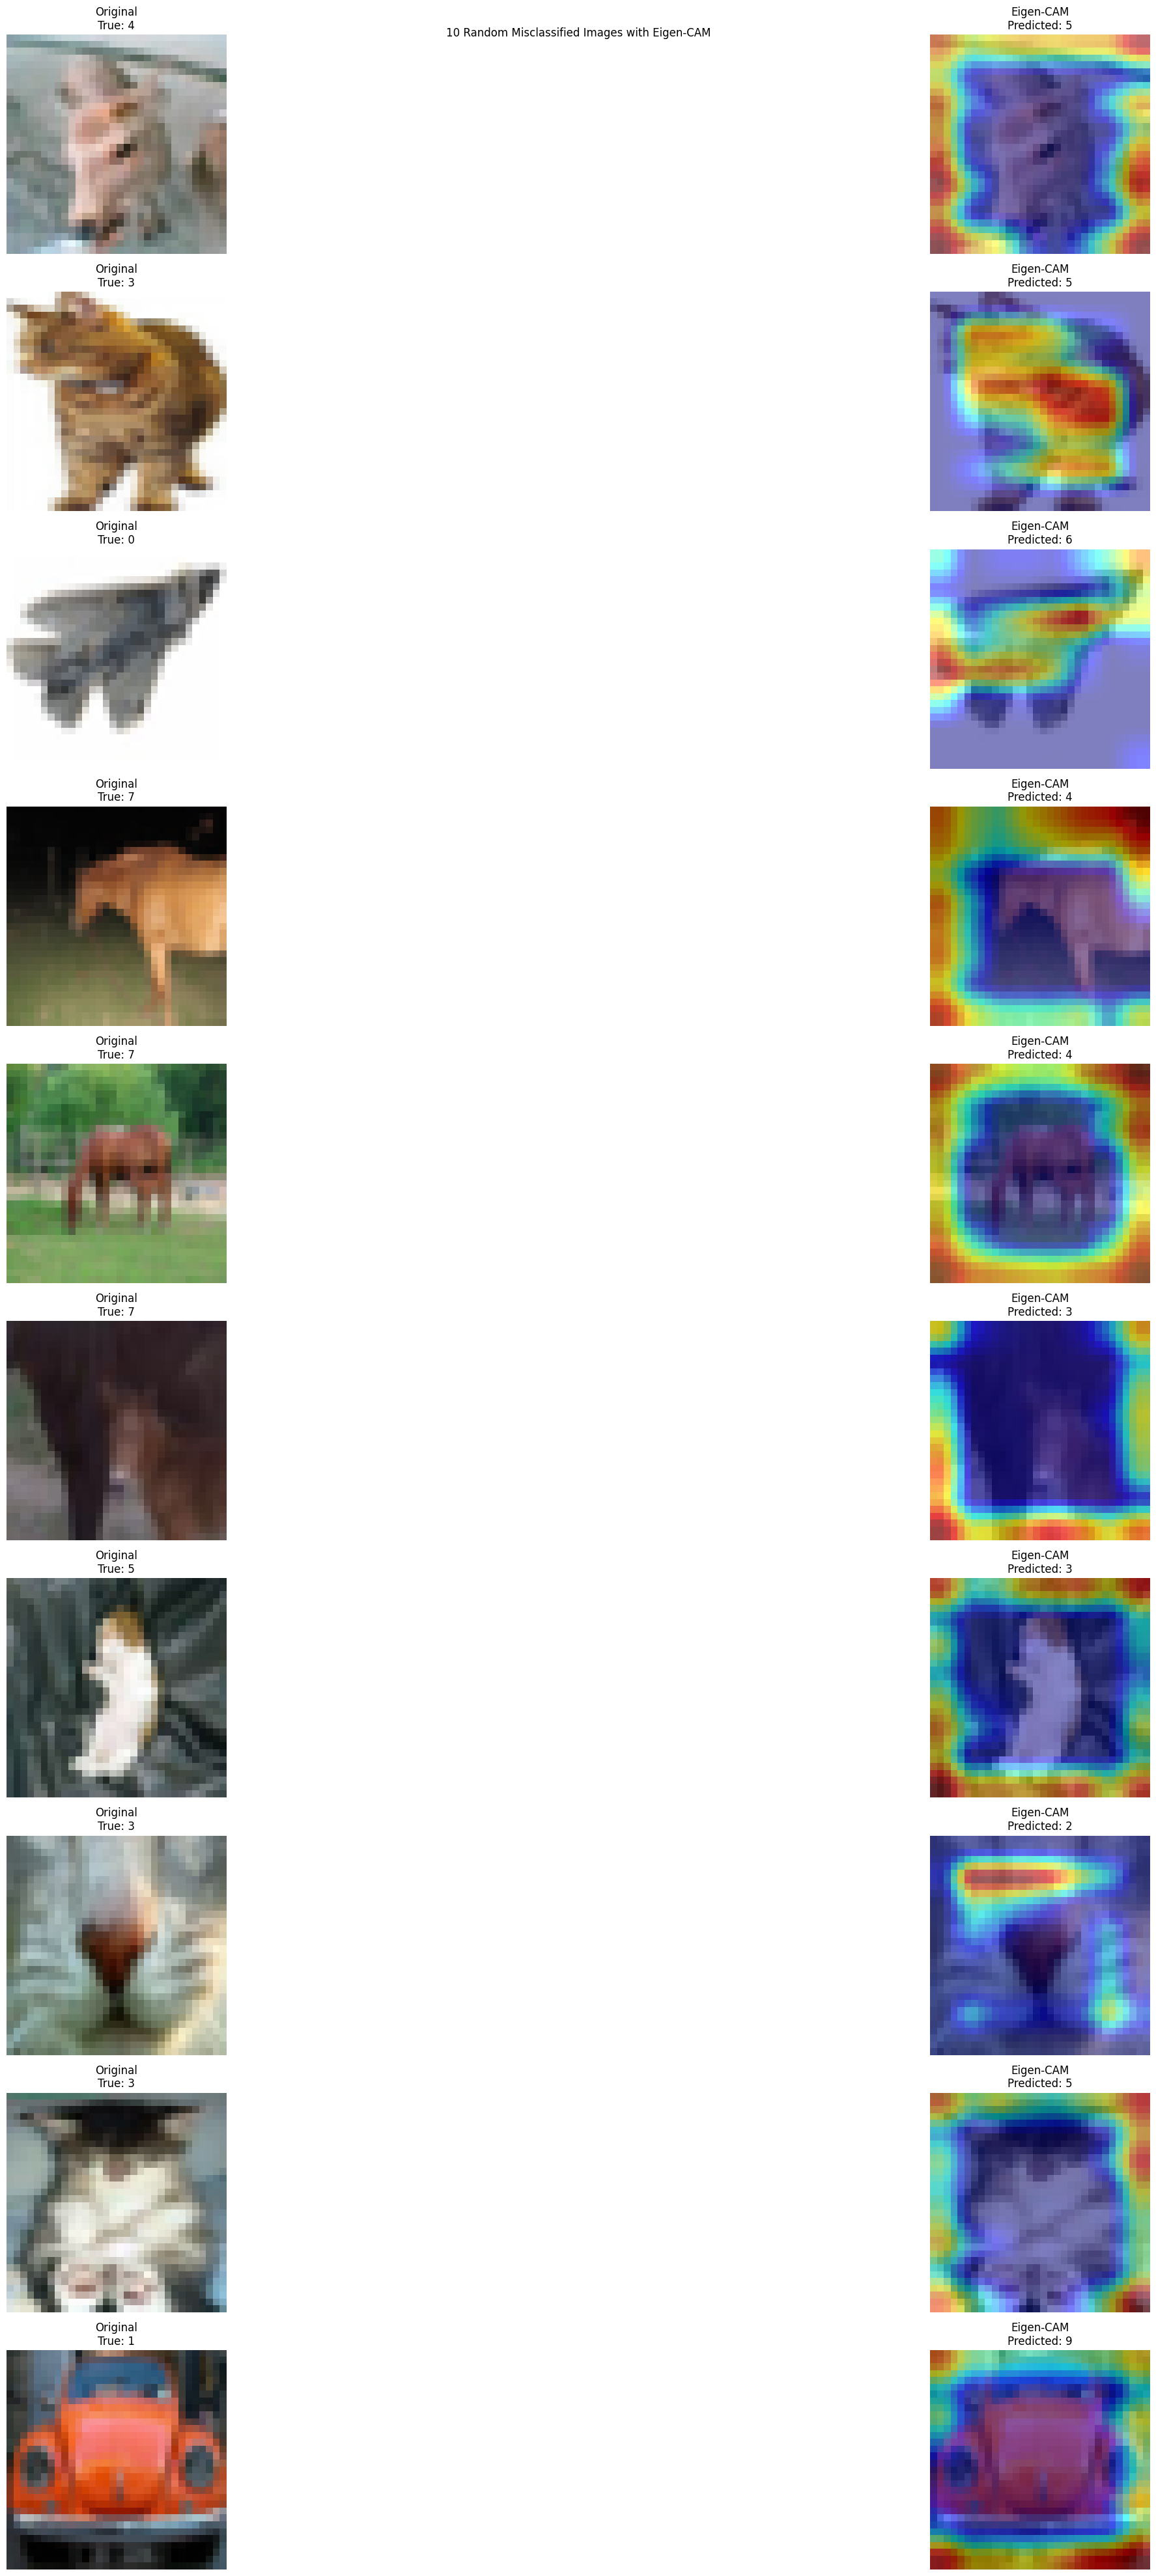

In [32]:
from pytorch_grad_cam import EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layers = [net.conv9]  # replace with your conv layer
eigencam = EigenCAM(model=net, target_layers=target_layers)

def get_eigencam_image(index):
    test_image = test_images[index]
    image_np = np.float32(test_image) / 255.0

    input_tensor = preprocess_image(
        image_np,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ).to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(input_tensor)
        predicted_class = outputs.argmax(dim=1).item()

    # Eigen-CAM is gradient-free, targets optional
    grayscale_cam = eigencam(
        input_tensor=input_tensor,
        targets=[ClassifierOutputTarget(predicted_class)]
    )[0, :]

    cam_image = show_cam_on_image(image_np, grayscale_cam, use_rgb=True)
    return image_np, cam_image, predicted_class


plt.figure(figsize=(40, 40))
for i, idx in enumerate(random_correct_indices):
    orig, cam_img, pred = get_eigencam_image(idx)
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original\nTrue: {all_true_labels[idx]}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(cam_img)
    plt.title(f"Eigen-CAM\nPredicted: {pred}")
    plt.axis("off")

plt.suptitle("10 Random Correctly Classified Images with Eigen-CAM")
plt.tight_layout()
plt.show()


plt.figure(figsize=(40, 40))
for i, idx in enumerate(random_wrong_indices):
    orig, cam_img, pred = get_eigencam_image(idx)
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original\nTrue: {all_true_labels[idx]}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(cam_img)
    plt.title(f"Eigen-CAM\nPredicted: {pred}")
    plt.axis("off")

plt.suptitle("10 Random Misclassified Images with Eigen-CAM")
plt.tight_layout()
plt.show()

These results are actually turning out better than expected as the images are more clearly classified into proper boxes where we can claearly distinguish the background and the object which shows how eigen cam is accurate 

1) The main advantage is that when gradients vanish or explode we use to get either clear or messy heatmap but in this case we dont need gradients its giving important to feautres for eg: If our network has a sleepy cat (gradients vanish) Eigen CAM still knows where the cat is hiding.
2) It can highlight dominant structures in the feature maps without specifying a class.
3) Captures dominant activations across channels, sometimes giving a cleaner map even if spatial resolution is low

The Major Disadvantage of this method is that:

1) Its not class specific only dominant features are valued as we can see in the last example of misclassifcation it dominates the class plane capturing more of the terrain features

2) And EIGEN CAM majorly focuses or pushes for one specific feautre wont help in multi class classifcation

3) For example if we have a noise in our code then there would be absolute destruction as it would learn the noises more than the actual features

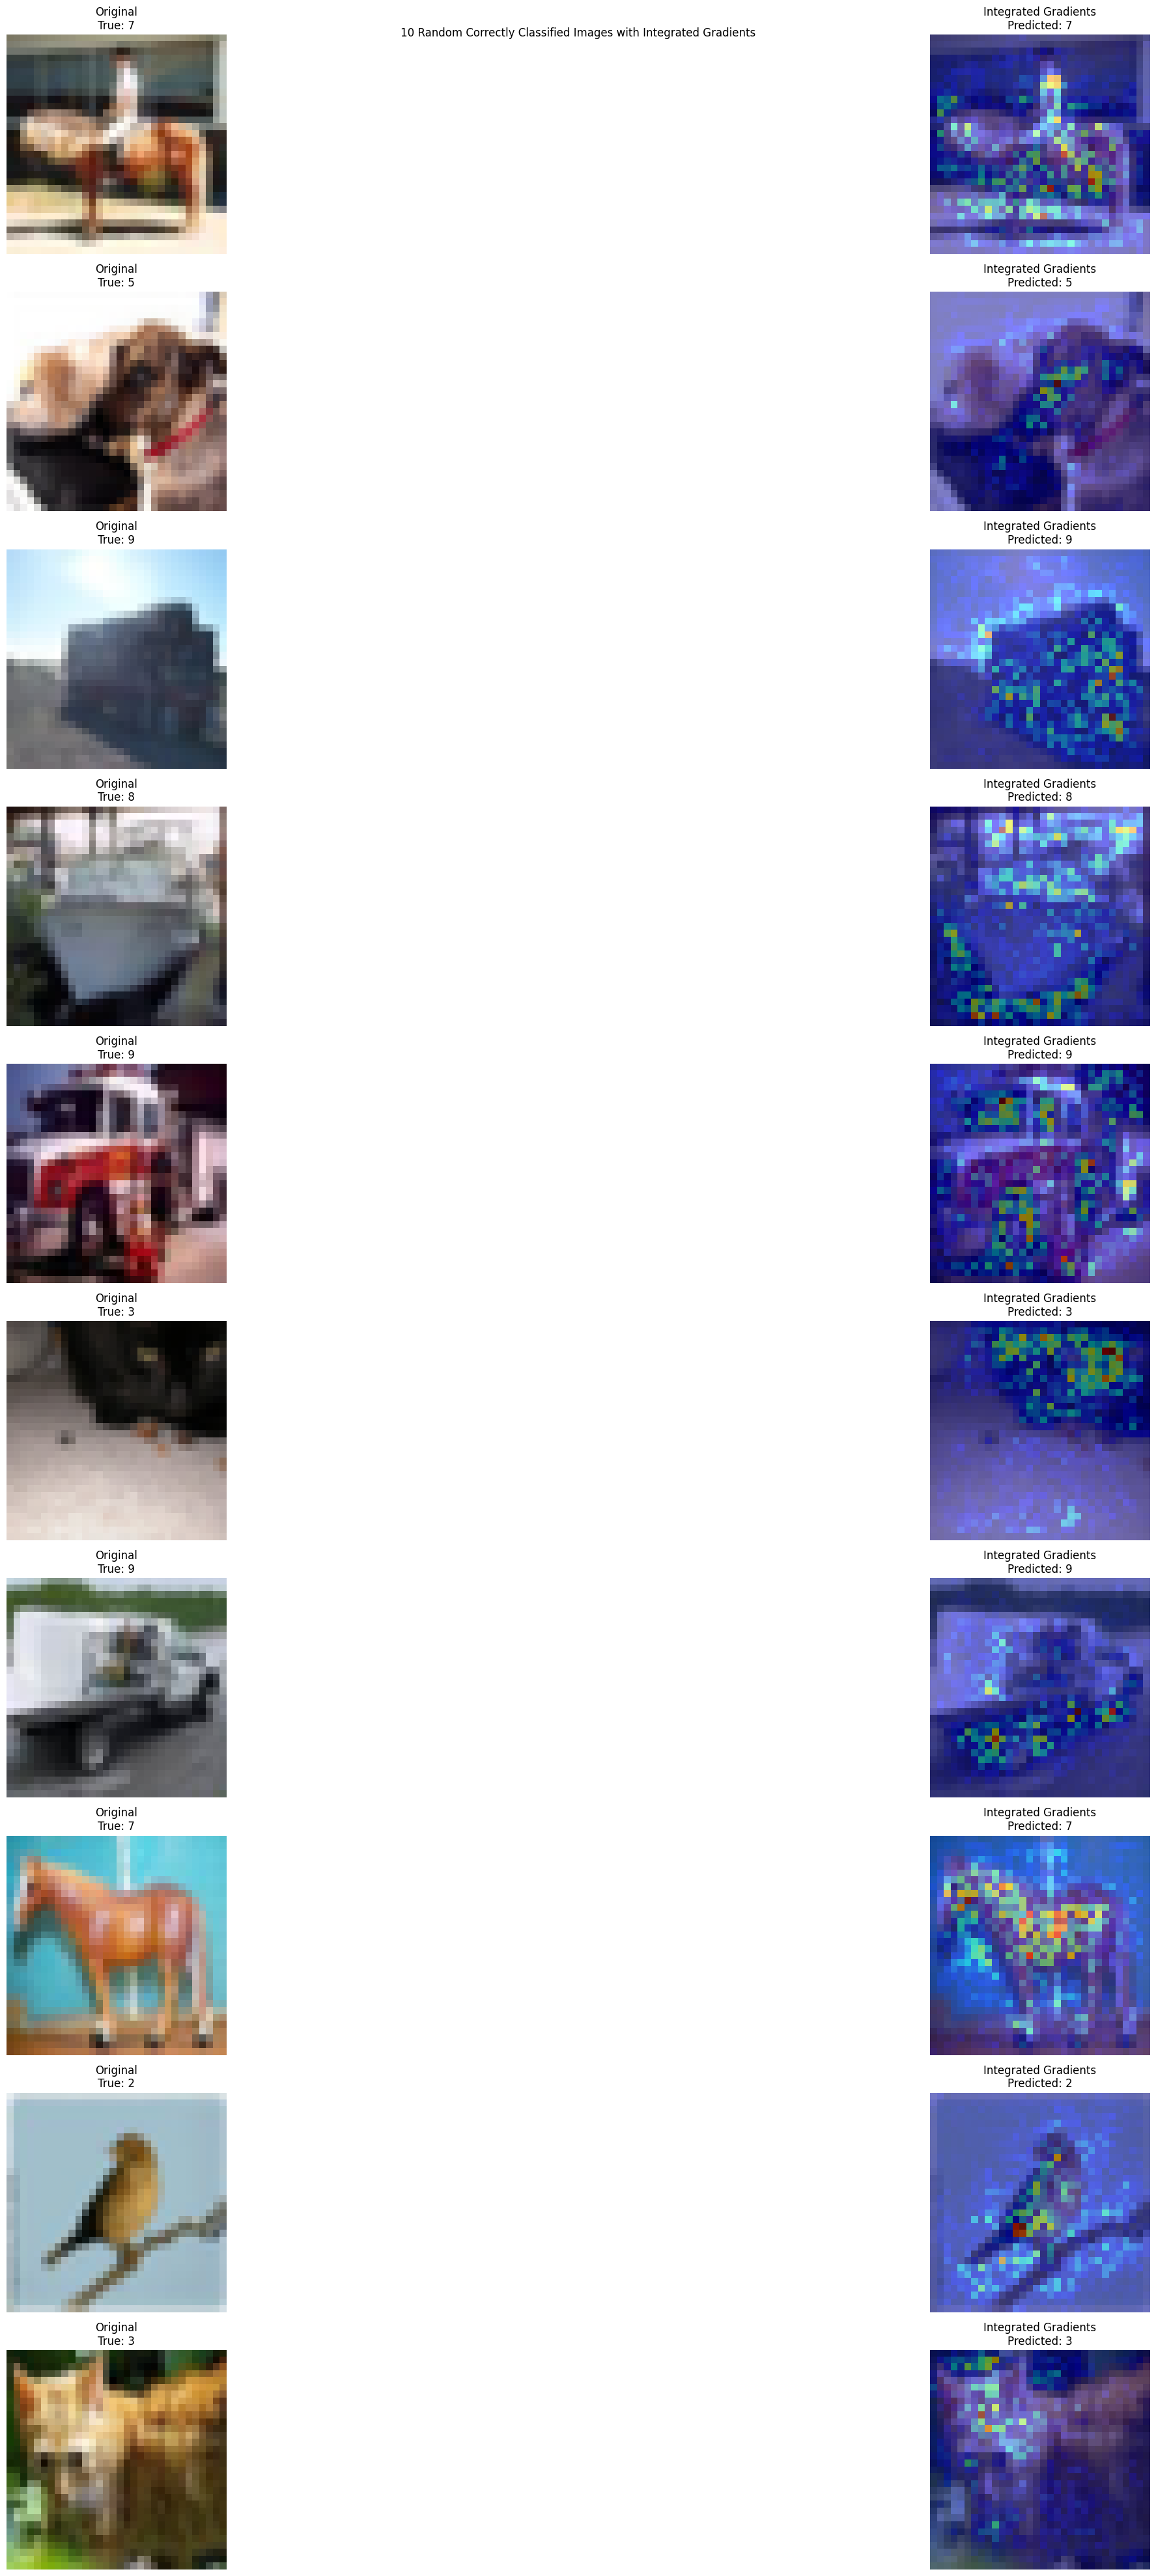

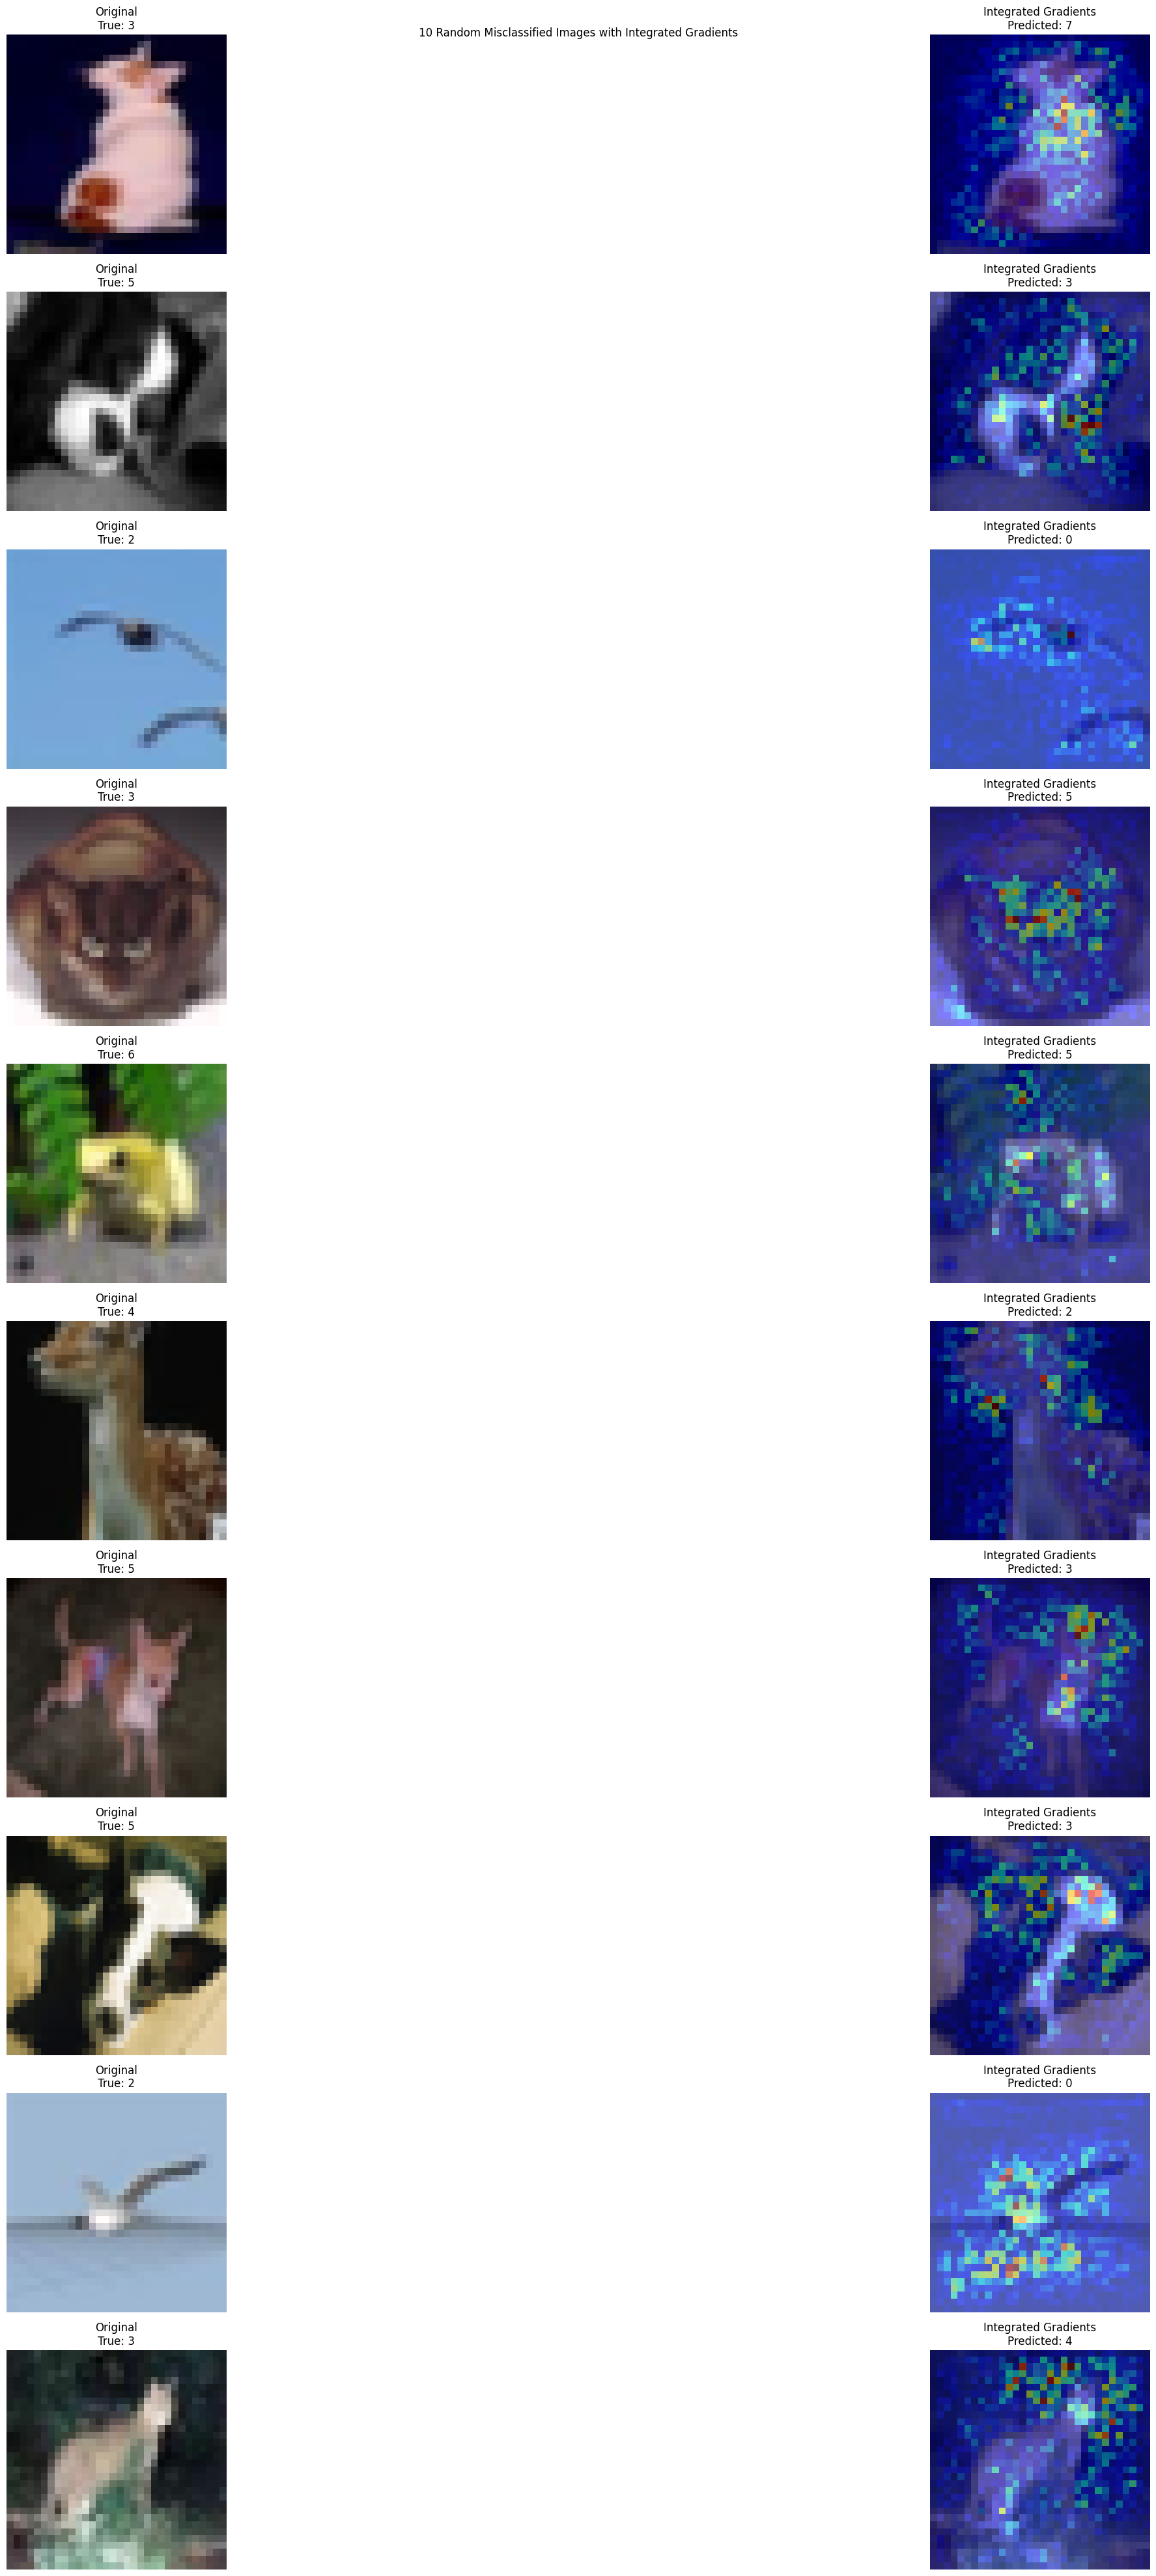

In [34]:
from captum.attr import IntegratedGradients

ig = IntegratedGradients(net)

def preprocess_image(img_np, mean, std):
    img_tensor = torch.tensor(img_np.transpose(2,0,1)).unsqueeze(0).float()
    for t, m, s in zip(img_tensor[0], mean, std):
        t.sub_(m).div_(s)
    return img_tensor


def get_ig_image(index, steps=50, baseline_type='black'):
    test_image = test_images[index]
    image_np = np.float32(test_image) / 255.0

    input_tensor = preprocess_image(
        image_np,
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ).to(device)

    net.eval()
    with torch.no_grad():
        outputs = net(input_tensor)
        predicted_class = outputs.argmax(dim=1).item()

    # Baseline for IG
    if baseline_type == 'black':
        baseline = torch.zeros_like(input_tensor).to(device)
    elif baseline_type == 'random':
        baseline = torch.rand_like(input_tensor).to(device)

    # Compute integrated gradients
    attributions, delta = ig.attribute(
        input_tensor,
        baselines=baseline,
        target=predicted_class,
        return_convergence_delta=True,
        n_steps=steps
    )

    # Convert attribution to numpy for visualization
    attr_np = attributions.squeeze().cpu().detach().numpy().transpose(1,2,0)
    attr_np = np.sum(np.abs(attr_np), axis=2)  # aggregate over channels
    attr_np = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min() + 1e-8)  # normalize

    # Overlay on original image
    cam_image = np.uint8(255 * image_np)
    heatmap = np.uint8(255 * attr_np)
    heatmap = plt.cm.jet(heatmap)[:, :, :3]
    overlay = 0.5 * cam_image + 0.5 * (heatmap * 255)
    overlay = np.uint8(overlay)

    return image_np, overlay, predicted_class

num_samples = 10
random_correct_indices = random.sample(correct_indices, min(num_samples, len(correct_indices)))
plt.figure(figsize=(40, 40))
for i, idx in enumerate(random_correct_indices):
    orig, ig_img, pred = get_ig_image(idx)
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original\nTrue: {all_true_labels[idx]}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(ig_img)
    plt.title(f"Integrated Gradients\nPredicted: {pred}")
    plt.axis("off")

plt.suptitle("10 Random Correctly Classified Images with Integrated Gradients")
plt.tight_layout()
plt.show()

random_wrong_indices = random.sample(misclassified_indices, min(num_samples, len(misclassified_indices)))
plt.figure(figsize=(40, 40))
for i, idx in enumerate(random_wrong_indices):
    orig, ig_img, pred = get_ig_image(idx)
    
    plt.subplot(num_samples, 2, 2*i+1)
    plt.imshow(orig)
    plt.title(f"Original\nTrue: {all_true_labels[idx]}")
    plt.axis("off")
    
    plt.subplot(num_samples, 2, 2*i+2)
    plt.imshow(ig_img)
    plt.title(f"Integrated Gradients\nPredicted: {pred}")
    plt.axis("off")

plt.suptitle("10 Random Misclassified Images with Integrated Gradients")
plt.tight_layout()
plt.show()

**Major Advantages**:

1) It’s class-specific, so it highlights exactly what the network “used” to predict a particular class.

2) Handles gradient issues better than raw gradients by integrating along the baseline path. 

3) The attributions sum up to the difference between input and baseline, giving a solid measure of feature importance.

**Major Disadvantages**:

1) Sensitive to the baseline – a bad choice can mislead the explanation.

2) Slower than CAM-based methods since it needs multiple forward/backward passes.

3) Can be noisy for fine textures, sometimes highlighting irrelevant pixels.

4) Less smooth visually compared to CAMs, since it works pixel-wise.